### Script referencing Python files to make RSAM, Spectra, PPSD, and Temporal Plots for each day in a time range

In [2]:
import obspy
from obspy import read, UTCDateTime
from obspy.io.xseed import Parser
from obspy.signal import PPSD
import numpy as np
import matplotlib.pyplot as plt
from obspy.imaging.cm import pqlx
import os
from obspy.clients.fdsn import Client
from obspy.clients import fdsn
from fractions import Fraction
import waveformUtils
import getData
import PPSD
import spectraPlay
import importlib
importlib.reload(waveformUtils)
importlib.reload(getData)
importlib.reload(PPSD)
importlib.reload(spectraPlay)

Station: ZE.2304..GPZ
Path 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2304/GPZ' already exists.
Station: ZE.2304..GP1
Path 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2304/GP1' already exists.
Station: ZE.2304..GP1
Path 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2304/GP1' already exists.


<module 'spectraPlay' from 'C:\\Users\\zzawol\\Documents\\MORA_winter\\FluvialSeismology_Analysis\\spectraPlay.py'>

In [2]:
# setting up parameters

# define start and end time for the data range
start_date = UTCDateTime(2023, 7, 24) # Start time
end_date = UTCDateTime(2023, 7, 26) # End time
delta = 86400  # 1 day in seconds
stas = [2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 
        'G2301', 'G2302', 'G2303', 'G2304', 'G2305', 'G2306', 'G2307', 'G2308', 'G2309', 'G2310', 'G2311',
        'G2312', 'G2313', 'G2314', 'G2315', 'G2316'] 
stas = ['ZE.2304..GPZ'] # station IDs

# set station info
nowsta = stas[0]
network, station, location, channel = nowsta.split('.')
print(f"Station: {nowsta}")

# define path where .mseed files are stored
path = 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2304/GPZ'

# check if the path exists, create if not
if not os.path.exists(path):
    print(f"Path '{path}' does not exist. Creating directory...")
    os.makedirs(path, exist_ok=True)
else:
    print(f"Path '{path}' already exists.")

file_pattern = f'{path}/{network}.{station}.*.{channel}*.mseed'

# set up IRIS client
DATASELECT = 'http://service.iris.edu/ph5ws/dataselect/1'
c = fdsn.client.Client(
    service_mappings={
        'dataselect': DATASELECT,
    },
)

# IRIS credentials
username = 'zoe_zawol@partner.nps.gov'
password = 'rJXKed4LZUHUE05g'
c.set_credentials(username, password)

# set up metadata
client = Client("IRISPH5", timeout=600)
inv = client.get_stations(network=network, station=station, location=location, channel=channel, level='response') 

Station: ZE.2304..GPZ
Path 'C:/Users/zzawol/Documents/seismic-data-iris/seismic_data/NO2304/GPZ' already exists.



Processing data for 2023-07-24T00:00:00.000000Z to 2023-07-25T00:00:00.000000Z
Length of S: 49
Checking if any missing data for 2023-07-24T00:00:00.000000Z to 2023-07-25T00:00:00.000000Z, downloading if necessary.
Checking data for station ZE.2304..GPZ from 2023-07-24T00:00:00.000000Z to 2023-07-24T00:30:00.000000Z
Data for ZE.2304..GPZ from 2023-07-24T00:00:00.000000Z to 2023-07-24T00:30:00.000000Z already stored locally. Skipping download.
Checking data for station ZE.2304..GPZ from 2023-07-24T00:30:00.000000Z to 2023-07-24T01:00:00.000000Z
Data for ZE.2304..GPZ from 2023-07-24T00:30:00.000000Z to 2023-07-24T01:00:00.000000Z already stored locally. Skipping download.
Checking data for station ZE.2304..GPZ from 2023-07-24T01:00:00.000000Z to 2023-07-24T01:30:00.000000Z
Data for ZE.2304..GPZ from 2023-07-24T01:00:00.000000Z to 2023-07-24T01:30:00.000000Z already stored locally. Skipping download.
Checking data for station ZE.2304..GPZ from 2023-07-24T01:30:00.000000Z to 2023-07-24T02:

C:\Users\zzawol\Documents\MORA_winter\FluvialSeismology_Analysis\spectraPlay.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f1.show() # comment this out when running file independently, uncomment for whole screening process


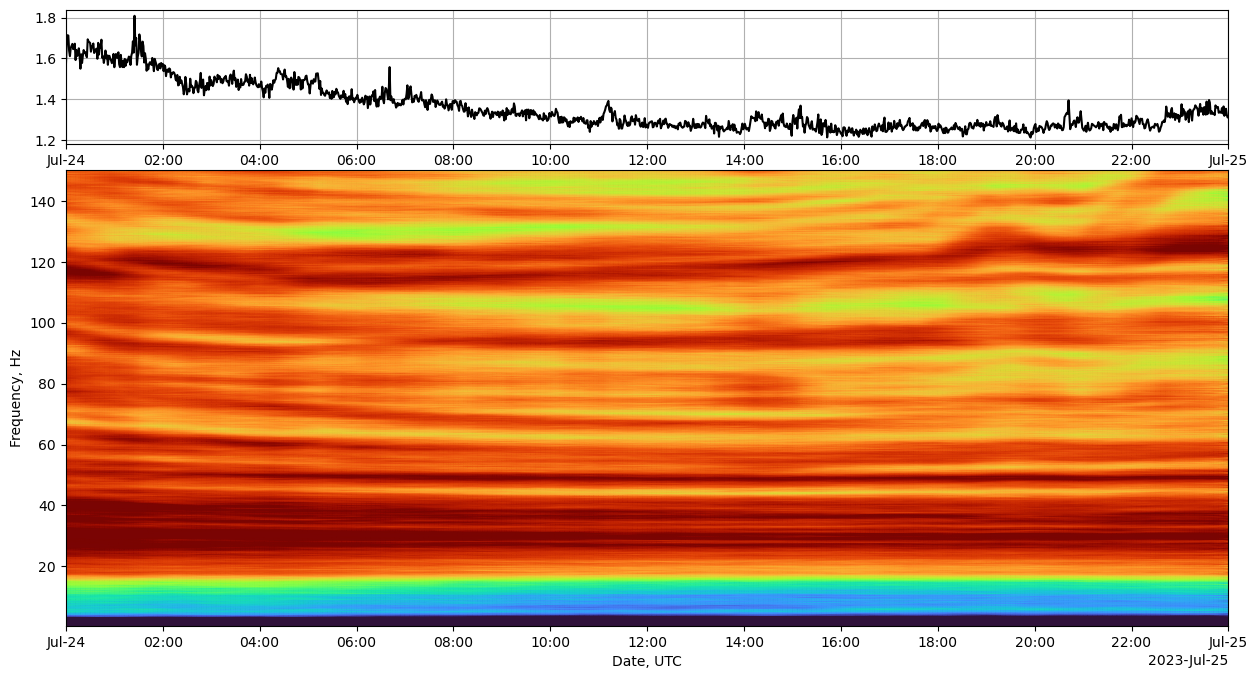

<Figure size 640x480 with 0 Axes>

Enter frequency values for temporal plot (comma-separated, takes in fractions and decimals):


Example (0.5, 50, 1/100) :  30, 50, 100, 120


periods: [0.03333333333333333, 0.02, 0.01, 0.008333333333333333]
freqs: [30.0, 50.0, 100.0, 120.0]
Making PPSD and Temporal Plots
Trace added to PPSD
Data accumulated for 1.0-day periods starting on 2023-07-24T00:00:00.000000Z


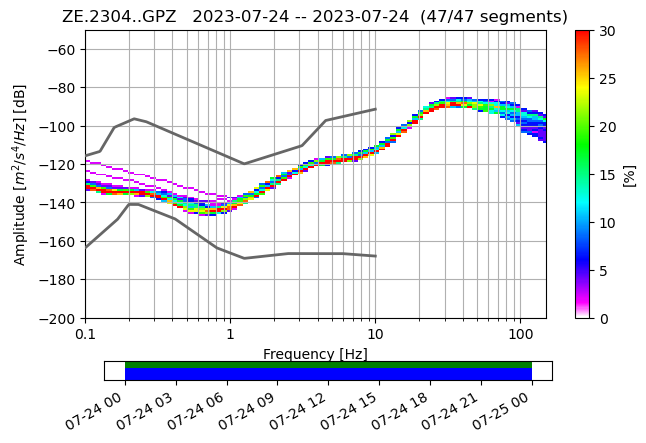

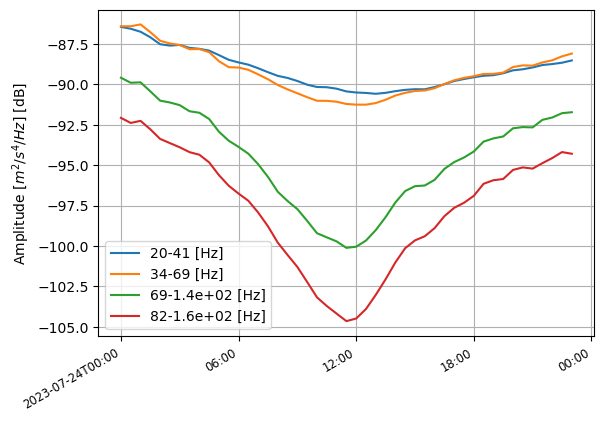

Inputted frequencies: [30.0, 50.0, 100.0, 120.0] --> periods: ['0.0333', '0.0200', '0.0100', '0.0083']

Processing data for 2023-07-25T00:00:00.000000Z to 2023-07-26T00:00:00.000000Z
Length of S: 49
Checking if any missing data for 2023-07-25T00:00:00.000000Z to 2023-07-26T00:00:00.000000Z, downloading if necessary.
Checking data for station ZE.2304..GPZ from 2023-07-25T00:00:00.000000Z to 2023-07-25T00:30:00.000000Z
Data for ZE.2304..GPZ from 2023-07-25T00:00:00.000000Z to 2023-07-25T00:30:00.000000Z already stored locally. Skipping download.
Checking data for station ZE.2304..GPZ from 2023-07-25T00:30:00.000000Z to 2023-07-25T01:00:00.000000Z
Data for ZE.2304..GPZ from 2023-07-25T00:30:00.000000Z to 2023-07-25T01:00:00.000000Z already stored locally. Skipping download.
Checking data for station ZE.2304..GPZ from 2023-07-25T01:00:00.000000Z to 2023-07-25T01:30:00.000000Z
Data for ZE.2304..GPZ from 2023-07-25T01:00:00.000000Z to 2023-07-25T01:30:00.000000Z already stored locally. Skipp

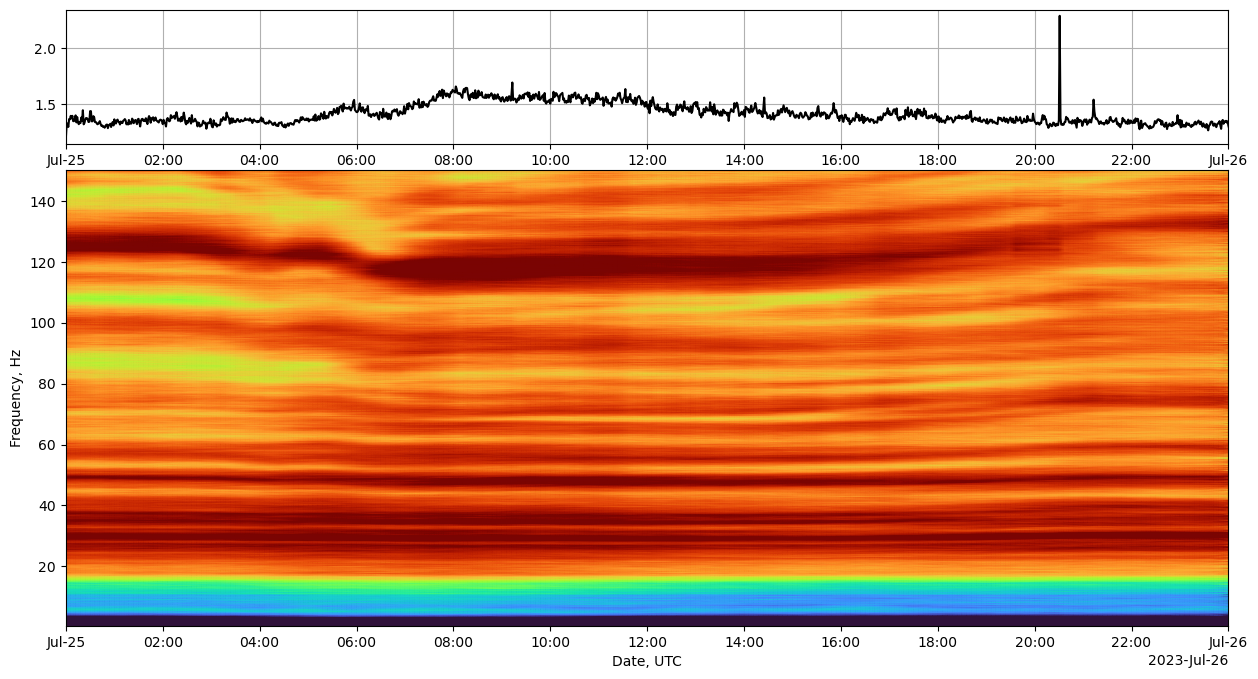

<Figure size 640x480 with 0 Axes>

Enter frequency values for temporal plot (comma-separated, takes in fractions and decimals):


Example (0.5, 50, 1/100) :  30, 50, 100, 120


periods: [0.03333333333333333, 0.02, 0.01, 0.008333333333333333]
freqs: [30.0, 50.0, 100.0, 120.0]
Making PPSD and Temporal Plots
Trace added to PPSD
Data accumulated for 1.0-day periods starting on 2023-07-25T00:00:00.000000Z


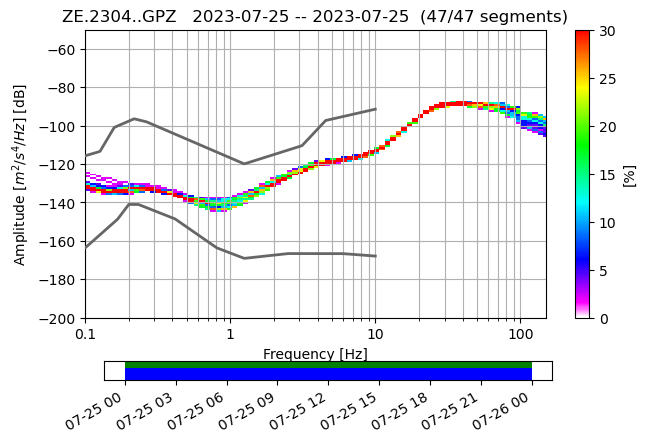

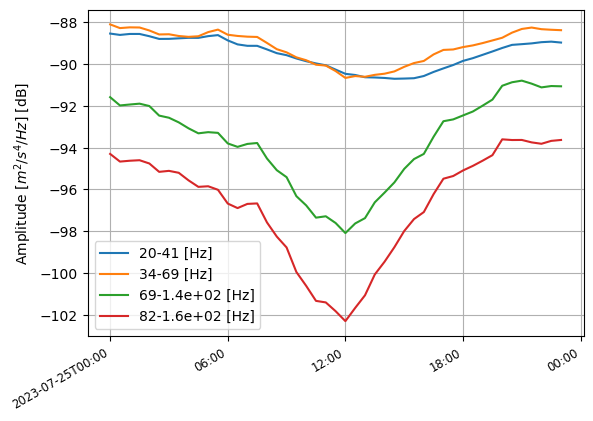

Inputted frequencies: [30.0, 50.0, 100.0, 120.0] --> periods: ['0.0333', '0.0200', '0.0100', '0.0083']
Analysis for ['ZE.2304..GPZ'] from 2023-07-24T00:00:00.000000Z to 2023-07-26T00:00:00.000000Z complete.


In [5]:
## main function to process data
def process_data(start_date, end_date, stas, path):
    """Main function to run through each day of data in timeframe and perform analyses"""
    delta = 86400  # 1 day in seconds
    current_date = start_date
    
    while current_date < end_date:
        t1 = current_date
        t2 = current_date + delta # the next day
        print(f"\nProcessing data for {t1} to {t2}")

        try:
            # reading local data for current date range
            S = obspy.read(file_pattern, starttime=t1, endtime=t2)
            
            # uses get_iris_data to ensure the data for this time range is downloaded
            print(f"Checking if any missing data for {t1} to {t2}, downloading if necessary.")
            getData.get_iris_data(t1, t2, stas, path)  # downloads any missing data if necessary

            # after calling get_iris_data, re-read local data (after ensuring it's downloaded)
            S = obspy.read(file_pattern, starttime=t1, endtime=t2)
            
            S1 = S.copy() # create a copy of the original stream for spectra

            # read an extra 6 mins of data to extend the stream
            spec_end = t2 + (6*60) # 6 minutes beyond original end time
            try:
                S_ext = obspy.read(file_pattern, starttime=t2, endtime=spec_end) # read only the extra data
            
                print(f"Checking if any missing data for {t2} to {spec_end}, downloading if necessary.")
                getData.get_iris_data(t2, spec_end, stas, path) # downloads any missing data if necessary

                # after calling get_iris_data, re-read local data (after ensuring it's downloaded)
                S_ext = obspy.read(file_pattern, starttime=t2, endtime=spec_end) # read only the extra data
                if S_ext[0].stats.sampling_rate != 350: # extra check
                    S_ext.resample(350)
                else:
                    pass

                # add extra 6 mins of data to copied stream
                S1.extend(S_ext) # now S1 contains the original data + 6 minutes, and S is untouched
                S1.merge(method=1) # avoid duplicates
                
            except Exception as e:
                print(f"An error occurred while processing data from {t2} to {spec_end}: {e}")
                
            print("Making spectrogram")
            
            # plot scectrogram and RSAM
            f1 = spectraPlay.plot_spectrogram(S1, t1, spec_end)  # pass S1 to plot_spectrogram function

            # ask user for frequency values after spectrogram
            print("Enter frequency values for temporal plot (comma-separated, takes in fractions and decimals):")
            user_inputs = input("Example (0.5, 50, 1/100) : ").split(',')
            
            # process user input - converts fractions and regular floats
            user_freqs = []
            user_periods = []
            for freq in user_inputs:
                try:
                    freq = freq.strip()  # clean up extra spaces
                    if '/' in freq:
                        user_freqs.append(float(Fraction(freq)))  # handle fraction
                    else:
                        user_freqs.append(float(freq))  # handle float
                except ValueError:
                    print(f"Invalid input: {freq}. Using default values.")

            user_periods = [1 / freq for freq in user_freqs]  # converts to periods for temporal plot
            
            # if user didn't provide any valid values, set defaults
            if not user_freqs:
                print("No valid input detected. Using default frequency values.")
                user_freqs = [100, 10, 1]  # default frequencies in Hz

            # plot PPSD
            print("Making PPSD and Temporal Plots")
            PPSD.plot_ppsd(S, inv, t1, t2, user_periods)
            
            round_periods = ['%.4f' % per for per in user_periods]
            print(f"Inputted frequencies: {user_freqs} --> periods: {round_periods}")  # for checking
            # print(user_values)  # for checking
            
        except Exception as e:
            print(f"An error occurred while processing data from {t1} to {t2}: {e}")
        
        current_date += delta  # move to next day

# call function
process_data(start_date, end_date, stas, path)
print(f"Analysis for {stas} from {start_date} to {end_date} complete.")